In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
%cd /content/drive/MyDrive/Independent\ Study/fingerprints
import pandas as pd
df = pd.read_csv('FULLDATASET_cleaned.csv')
df.head()

/content/drive/MyDrive/Independent Study/fingerprints


,Unnamed: 0,label,ending0,ending1,ending2,ending3,qwen_0.5b_pred,qwen_0.5b_correct,qwen_1.5b_pred,qwen_1.5b_correct,...,phi3_mini_pred,phi3_mini_correct,sailor2_1b_pred,sailor2_1b_correct,llama3.2_1b_pred,llama3.2_1b_correct,llama3_8b_pred,llama3_8b_correct,gemma2_9b_pred,gemma2_9b_correct
0,0,3,is using wrap to wrap a pair of skis,is ripping level tiles off,is holding a rubiks cube,starts pulling up roofing on a roof,1,False,3,True,...,0,False,3,True,1,False,0,False,3,True
1,1,3,swings and lands in her arms,pulls the barbell forward,pulls a rope attached to the barbell,stands and lifts the weight over her head,0,False,3,True,...,-2,False,1,False,1,False,0,False,3,True
2,2,2,are then shown paddling down a river in a boat...,are driving the canoe they go down the river f...,sit in a canoe while the man paddles,walking go down the rapids while the man in hi...,2,True,2,True,...,1,False,0,False,2,True,0,False,2,True
3,3,2,runs into a car,gets in a mat,lifts his body above the height of a pole,stands on his hands and springs,3,False,3,False,...,3,False,3,False,1,False,0,False,2,True
4,4,1,turns his body around on the mat,gets up from the mat,continues to lift his body over the pole,wiggles out of the mat,3,False,1,True,...,3,False,1,True,1,True,2,False,1,True


# Task
Analyze the disagreement among multiple models on the dataset located at "FULLDATASET_cleaned.csv". This analysis involves:
1.  Calculating various disagreement metrics (prediction entropy, unique predictions, variance, disagreement rate, and a composite score) for all samples.
2.  Identifying and selecting the top N samples exhibiting high disagreement based on the composite score.
3.  Generating "confusion matrix fingerprints" and "behavioral fingerprints" for each model to characterize their predictive patterns.
4.  Applying PCA and K-means clustering to the normalized behavioral fingerprints to identify and assign models to optimal clusters.
5.  Exporting the full disagreement scores, the full rows of the top-N high-disagreement samples, and the model-level results (including clustering information) to CSV files.

In [58]:
N = 1000

## Setup and Imports

### Subtask:
Import all necessary Python libraries for data manipulation, numerical operations, machine learning (e.g., scikit-learn), plotting (matplotlib, seaborn), and warnings.


**Reasoning**:
The subtask requires importing several Python libraries for data manipulation, numerical operations, machine learning, plotting, and warnings. This code block will import all the specified libraries.



In [59]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, silhouette_score
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

print("Libraries imported successfully.")

Libraries imported successfully.


## Load Data and Extract Model Information

### Subtask:
Load the dataset and extract model names from prediction columns.


**Reasoning**:
The subtask requires identifying prediction columns and extracting model names from the already loaded DataFrame. I will iterate through the columns, filter those ending with '_pred', and then extract the model names by removing the '_pred' suffix.



In [60]:
model_pred_cols = [col for col in df.columns if col.endswith('_pred')]
model_names = [col.replace('_pred', '') for col in model_pred_cols]

print(f"Identified {len(model_pred_cols)} prediction columns.")
print(f"Extracted {len(model_names)} unique model names.")
print("Model Prediction Columns:", model_pred_cols[:5]) # Display first 5
print("Model Names:", model_names[:5]) # Display first 5

Identified 22 prediction columns.
Extracted 22 unique model names.
Model Prediction Columns: ['qwen_0.5b_pred', 'qwen_1.5b_pred', 'qwen_7b_pred', 'stable_zephyr_3b_pred', 'stable2_1.6b_pred']
Model Names: ['qwen_0.5b', 'qwen_1.5b', 'qwen_7b', 'stable_zephyr_3b', 'stable2_1.6b']


## Define Disagreement Metrics

### Subtask:
Define the `compute_disagreement_metrics` function, which calculates prediction entropy, unique predictions count, prediction variance, disagreement rate, and a composite disagreement score.


**Reasoning**:
I need to define the `compute_disagreement_metrics` function as specified, which calculates prediction entropy, unique predictions count, prediction variance, disagreement rate, and a composite disagreement score. This requires importing `scipy.stats` for entropy calculation and applying several row-wise operations on the model prediction columns.



In [61]:
import numpy as np
import pandas as pd
from scipy.stats import entropy


def compute_disagreement_metrics(df, model_pred_cols):
    """
    Computes per-example disagreement metrics across model predictions.
    Each row in the output corresponds to ONE dataset example.
    """

    preds = df[model_pred_cols].to_numpy()
    n_models = preds.shape[1]

    disagreement_metrics = pd.DataFrame(index=df.index)

    # 1. Prediction entropy (row-wise)
    disagreement_metrics["entropy"] = [
        entropy(pd.Series(row).value_counts(normalize=True))
        for row in preds
    ]

    # 2. Number of unique predictions (row-wise)
    disagreement_metrics["unique_predictions"] = [
        len(set(row)) for row in preds
    ]

    # 3. Disagreement rate (row-wise)
    disagreement_metrics["disagreement_rate"] = [
        1 - (pd.Series(row).value_counts().max() / n_models)
        for row in preds
    ]

    # 4. Composite disagreement score
    disagreement_metrics["composite_disagreement_score"] = (
        disagreement_metrics["entropy"]
        + disagreement_metrics["unique_predictions"]
        + disagreement_metrics["disagreement_rate"]
    )

    return disagreement_metrics



## Compute Disagreement Scores

### Subtask:
Apply the `compute_disagreement_metrics` function to the main DataFrame (`df`) to calculate disagreement scores for all samples.


**Reasoning**:
I will apply the previously defined `compute_disagreement_metrics` function to the main DataFrame `df` and the identified prediction columns `model_pred_cols` to calculate and store the disagreement scores. Then I will display the head and shape of the resulting DataFrame.



In [62]:
disagreement_scores = compute_disagreement_metrics(df, model_pred_cols)

print("First 5 rows of disagreement scores:")
print(disagreement_scores.head())

print(f"\nShape of disagreement scores: {disagreement_scores.shape}")

First 5 rows of disagreement scores:
    entropy  unique_predictions  disagreement_rate  \
0  1.097166                   4           0.454545   
1  1.324974                   5           0.500000   
2  1.423941                   5           0.681818   
3  1.477292                   5           0.636364   
4  1.112021                   5           0.363636   

   composite_disagreement_score  
0                      5.551712  
1                      6.824974  
2                      7.105759  
3                      7.113656  
4                      6.475657  

Shape of disagreement scores: (10042, 4)


**Reasoning**:
The next step is to identify the top N samples with the highest disagreement based on the 'composite_disagreement_score'. I will sort the `disagreement_scores` DataFrame by this score in descending order, select the top N indices, and then use these indices to filter the original `df` to create a new DataFrame `df_high_disagreement`.



In [63]:
df_high_disagreement = df.loc[disagreement_scores.sort_values(by='composite_disagreement_score', ascending=False).head(N).index]

print("First 5 rows of high disagreement samples:")
print(df_high_disagreement.head())

print(f"\nShape of high disagreement samples: {df_high_disagreement.shape}")

First 5 rows of high disagreement samples:
      Unnamed: 0  label                                            ending0  \
8449        8449      2  Reshape your hands after 10 and 20 drops of du...   
8055        8055      1  This oval should form a circle in the bottom e...   
5636        5636      3  Speak in a firm voice that focuses the convers...   
5037        5037      1  Because the plaintiff waited for permission to...   
5103        5103      3  Think about defining the two dividencies and s...   

                                                ending1  \
8449  Place the fingers of your two hands on the sid...   
8055   Click and hold the circle and tap on create oval   
5636  This is a good way to keep distance between yo...   
5037  Because you used obscene or hazardous material...   
5103  Doing this may help you organize the problem s...   

                                                ending2  \
8449  Do this to avoid painful application of the du...   
8055     While 

## Confusion Matrix and Behavioral Fingerprints

### Explanation

To characterize the predictive patterns of each model, we will generate two types of 'fingerprints':

1.  **Confusion Matrix Fingerprints**: These capture how each model's predictions align (or misalign) with the true labels across all classes. For a multi-class problem with `N` classes, a confusion matrix will be an `N x N` matrix. A confusion matrix fingerprint is essentially a flattened, normalized version of this matrix, representing the distribution of true vs. predicted classes. It provides a detailed view of a model's strengths and weaknesses for each class.

2.  **Behavioral Fingerprints**: These go beyond just accuracy and confusion matrices to capture a broader range of a model's predictive characteristics. They typically include metrics like accuracy, F1-score, precision, recall, and the individual components of the confusion matrix (e.g., true positives, false positives, etc., for each class). When normalized, these fingerprints provide a vector representing the model's overall 'behavior' or performance signature.

### Why are they useful?

By comparing these fingerprints across different models, we can:
*   **Identify similar models**: Models with similar fingerprints are likely to behave similarly on the data.
*   **Understand model biases**: Specific patterns in confusion matrix fingerprints can highlight systematic errors.
*   **Cluster models**: Behavioral fingerprints can be used as features for clustering algorithms to group models with similar performance profiles.
*   **Probe model robustness**: By comparing fingerprints on different subsets of data (e.g., high disagreement samples vs. all samples), we can assess how model behavior changes under varying conditions.

**Reasoning**:
The next step is to implement the `generate_confusion_matrix_fingerprint` function. This function will iterate through each model, calculate its confusion matrix against the true labels, normalize it, and flatten it into a vector to create a unique 'fingerprint' for each model's predictive behavior.



In [64]:
def generate_confusion_matrix_fingerprint(df, model_pred_cols, num_classes):
    """
    Generates a confusion matrix fingerprint for each model.

    Args:
        df (pd.DataFrame): The DataFrame containing 'label' and model prediction columns.
        model_pred_cols (list): List of column names for model predictions.
        num_classes (int): The number of unique classes in the 'label' column.

    Returns:
        dict: A dictionary where keys are model names and values are their
              flattened, normalized confusion matrix fingerprints.
    """
    fingerprints = {}
    true_labels = df['label']

    for pred_col in model_pred_cols:
        model_name = pred_col.replace('_pred', '')
        predictions = df[pred_col]

        # Filter out invalid predictions (-1, -2) if any
        valid_indices = predictions[predictions >= 0].index
        valid_true_labels = true_labels.loc[valid_indices]
        valid_predictions = predictions.loc[valid_indices]

        if not valid_indices.empty:
            # Calculate confusion matrix
            cm = confusion_matrix(valid_true_labels, valid_predictions, labels=range(num_classes))

            # Normalize confusion matrix by true label (row-wise sum)
            # This shows the proportion of predictions for each true class
            cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            cm_normalized = np.nan_to_num(cm_normalized) # Handle cases where a row sum is 0 (no true labels for a class)

            # Flatten the normalized confusion matrix to create the fingerprint
            fingerprints[model_name] = cm_normalized.flatten()
        else:
            # If no valid predictions, assign an array of zeros or NaNs
            # For now, let's use zeros of appropriate size
            fingerprints[model_name] = np.zeros(num_classes * num_classes)
            print(f"Warning: No valid predictions for model {model_name}. Assigning zero fingerprint.")

    print("Confusion matrix fingerprint generation function 'generate_confusion_matrix_fingerprint' defined.")
    return fingerprints


**Reasoning**:
The next step is to implement the `generate_behavioral_fingerprint` function. This function will compute various performance metrics (accuracy, F1-score, precision, recall, and flattened confusion matrix elements) for each model, and then combine and normalize them to form a comprehensive behavioral fingerprint. This builds upon the concept of confusion matrix fingerprints by including more detailed performance indicators.



In [65]:
def generate_behavioral_fingerprint(df, model_pred_cols, num_classes):
    """
    Generates a behavioral fingerprint for each model, including various metrics
    and flattened confusion matrix values.

    Args:
        df (pd.DataFrame): The DataFrame containing 'label' and model prediction columns.
        model_pred_cols (list): List of column names for model predictions.
        num_classes (int): The number of unique classes in the 'label' column.

    Returns:
        pd.DataFrame: A DataFrame where each row is a model's behavioral fingerprint.
    """
    all_model_behavioral_data = {}
    true_labels = df['label']

    for pred_col in model_pred_cols:
        model_name = pred_col.replace('_pred', '')
        predictions = df[pred_col]

        # Filter out invalid predictions (-1, -2)
        valid_indices = predictions[predictions >= 0].index
        valid_true_labels = true_labels.loc[valid_indices]
        valid_predictions = predictions.loc[valid_indices]

        if not valid_indices.empty:
            metrics = {
                'accuracy': accuracy_score(valid_true_labels, valid_predictions),
                'f1_score': f1_score(valid_true_labels, valid_predictions, average='macro', zero_division=0),
                'precision': precision_score(valid_true_labels, valid_predictions, average='macro', zero_division=0),
                'recall': recall_score(valid_true_labels, valid_predictions, average='macro', zero_division=0)
            }
            cm = confusion_matrix(valid_true_labels, valid_predictions, labels=range(num_classes))

            # Flatten confusion matrix and add to metrics
            for i in range(num_classes):
                for j in range(num_classes):
                    metrics[f'cm_true_{i}_pred_{j}'] = cm[i, j]
            all_model_behavioral_data[model_name] = metrics
        else:
            # Assign placeholder values if no valid predictions
            num_cm_elements = num_classes * num_classes
            metrics = {
                'accuracy': 0,
                'f1_score': 0,
                'precision': 0,
                'recall': 0
            }
            for i in range(num_classes):
                for j in range(num_classes):
                    metrics[f'cm_true_{i}_pred_{j}'] = 0
            all_model_behavioral_data[model_name] = metrics
            print(f"Warning: No valid predictions for model {model_name}. Assigning zero behavioral fingerprint.")

    behavioral_fingerprints_df = pd.DataFrame.from_dict(all_model_behavioral_data, orient='index')

    # Normalize the behavioral fingerprints
    scaler = StandardScaler()
    behavioral_fingerprints_scaled = scaler.fit_transform(behavioral_fingerprints_df)
    behavioral_fingerprints_df_normalized = pd.DataFrame(
        behavioral_fingerprints_scaled,
        columns=behavioral_fingerprints_df.columns,
        index=behavioral_fingerprints_df.index
    )

    print("Behavioral fingerprint generation function 'generate_behavioral_fingerprint' defined.")
    return behavioral_fingerprints_df_normalized

**Reasoning**:
I need to call the previously defined `generate_confusion_matrix_fingerprint` function. First, I will determine the number of unique classes from the 'label' column of the `df`. Then, I will pass the `df`, `model_pred_cols`, and `num_classes` to the function to generate the confusion matrix fingerprints for all models, and finally, display the first few entries and their shape.



In [66]:
num_classes = df['label'].nunique()

confusion_matrix_fingerprints = generate_confusion_matrix_fingerprint(df, model_pred_cols, num_classes)

# Convert to DataFrame for easier inspection
confusion_matrix_fingerprints_df = pd.DataFrame.from_dict(confusion_matrix_fingerprints, orient='index')

print("First 5 rows of Confusion Matrix Fingerprints:")
print(confusion_matrix_fingerprints_df.head())

print(f"\nShape of Confusion Matrix Fingerprints: {confusion_matrix_fingerprints_df.shape}")

Confusion matrix fingerprint generation function 'generate_confusion_matrix_fingerprint' defined.
First 5 rows of Confusion Matrix Fingerprints:
                        0         1         2         3         4         5   \
qwen_0.5b         0.299404  0.100199  0.201590  0.398807  0.272032  0.098592   
qwen_1.5b         0.051292  0.447316  0.299006  0.202386  0.004829  0.292555   
qwen_7b           0.636183  0.247316  0.073559  0.042942  0.088129  0.220926   
stable_zephyr_3b  0.104175  0.554672  0.170974  0.170179  0.014090  0.363929   
stable2_1.6b      0.488491  0.000853  0.066922  0.443734  0.486756  0.000000   

                        6         7         8         9         10        11  \
qwen_0.5b         0.228571  0.400805  0.272059  0.101780  0.224458  0.401703   
qwen_1.5b         0.454326  0.248290  0.018576  0.329334  0.402477  0.249613   
qwen_7b           0.415292  0.275654  0.274381  0.126161  0.432663  0.166796   
stable_zephyr_3b  0.338969  0.283011  0.030573  0.3494

**Reasoning**:
I need to call the previously defined `generate_behavioral_fingerprint` function for the full dataset. I will use the `df`, `model_pred_cols`, and `num_classes` as inputs, store the result, and then display its head and shape for verification.



In [67]:
behavioral_fingerprints_full_data = generate_behavioral_fingerprint(df, model_pred_cols, num_classes)

print("First 5 rows of Behavioral Fingerprints (Full Data):")
print(behavioral_fingerprints_full_data.head())

print(f"\nShape of Behavioral Fingerprints (Full Data): {behavioral_fingerprints_full_data.shape}")

Behavioral fingerprint generation function 'generate_behavioral_fingerprint' defined.
First 5 rows of Behavioral Fingerprints (Full Data):
                  accuracy  f1_score  precision    recall  cm_true_0_pred_0  \
qwen_0.5b        -1.036334 -0.704560  -1.100125 -1.022472         -0.306899   
qwen_1.5b        -0.998365 -0.865233   0.340032 -1.017941         -1.541330   
qwen_7b           2.805891  2.533455   1.665505  2.833482          1.368683   
stable_zephyr_3b  0.199478  0.333338   1.257269  0.209556         -1.278222   
stable2_1.6b     -1.286186 -1.873371  -2.561714 -1.246825          0.470555   

                  cm_true_0_pred_1  cm_true_0_pred_2  cm_true_0_pred_3  \
qwen_0.5b                -0.948581          0.166584          1.753677   
qwen_1.5b                 1.365461          1.123822          0.263415   
qwen_7b                   0.032170         -1.091500         -0.946292   
stable_zephyr_3b          2.081144         -0.134262          0.019060   
stable2_1.6b    

**Reasoning**:
Now that behavioral fingerprints have been generated for the full dataset, I need to do the same for the `df_high_disagreement` dataset. I will call the `generate_behavioral_fingerprint` function with `df_high_disagreement` and the other necessary parameters, store the result, and display its head and shape for verification.



In [68]:
behavioral_fingerprints_high_disagreement = generate_behavioral_fingerprint(df_high_disagreement, model_pred_cols, num_classes)

print("First 5 rows of Behavioral Fingerprints (High Disagreement Data):")
print(behavioral_fingerprints_high_disagreement.head())

print(f"\nShape of Behavioral Fingerprints (High Disagreement Data): {behavioral_fingerprints_high_disagreement.shape}")

Behavioral fingerprint generation function 'generate_behavioral_fingerprint' defined.
First 5 rows of Behavioral Fingerprints (High Disagreement Data):
                  accuracy  f1_score  precision    recall  cm_true_0_pred_0  \
qwen_0.5b         1.222762  1.461114   0.773273  0.887417         -0.136668   
qwen_1.5b        -0.892149 -0.773473  -0.627349 -1.375214         -1.389457   
qwen_7b           2.464262  2.358511   1.027821  2.753395          1.642292   
stable_zephyr_3b  0.350593  0.680934   1.969187 -0.069663         -1.088787   
stable2_1.6b     -0.847544 -1.987639  -2.194241 -0.506051          0.189057   

                  cm_true_0_pred_1  cm_true_0_pred_2  cm_true_0_pred_3  \
qwen_0.5b                -0.671746         -0.166848          1.729298   
qwen_1.5b                 1.435545          0.771207          0.282737   
qwen_7b                   0.395584         -0.941762         -0.903443   
stable_zephyr_3b          2.366038         -0.248417         -0.324819   
sta

## PCA and K-means Clustering on Behavioral Fingerprints

### Explanation

To identify and group models with similar predictive behaviors, we will apply two unsupervised machine learning techniques to the normalized behavioral fingerprints:

1.  **Principal Component Analysis (PCA)**: PCA is a dimensionality reduction technique. Behavioral fingerprints can be high-dimensional (many metrics). PCA transforms these features into a new set of orthogonal (uncorrelated) variables called Principal Components (PCs), ordered by the amount of variance they explain. This helps in:
    *   **Reducing complexity**: Making the data easier to visualize and interpret.
    *   **Noise reduction**: Focusing on the most significant patterns and potentially removing noise.
    *   **Improving clustering performance**: Clustering in lower dimensions can sometimes be more effective by reducing the impact of irrelevant features.

2.  **K-means Clustering**: K-means is a popular partitioning method for clustering. It aims to partition `n` observations into `k` clusters in which each observation belongs to the cluster with the nearest mean (cluster center or centroid). In our context, K-means will help us:
    *   **Group similar models**: Models that are close to each other in the PCA-reduced space (and thus have similar behavioral fingerprints) will be assigned to the same cluster.
    *   **Identify distinct model archetypes**: Each cluster will represent a group of models that exhibit similar performance characteristics and predictive patterns.

### Why are they useful?

By combining PCA and K-means, we can:
*   **Visualize model relationships**: Plotting models in a 2D or 3D PCA space, colored by their clusters, provides an intuitive way to see how models relate to each other.
*   **Quantify model similarity/dissimilarity**: The distance between models in the feature space directly reflects their behavioral similarity.
*   **Optimize ensemble strategies**: Understanding model clusters can inform decisions on how to combine models (e.g., using models from different clusters for diversity).
*   **Diagnose model issues**: Models in an unexpected cluster or isolated points might indicate unique behaviors or potential issues.

**Reasoning**:
Now that the behavioral fingerprints for the full dataset have been generated and the concepts of PCA and K-means have been explained, the next step is to apply PCA to reduce the dimensionality of these fingerprints. This will prepare the data for clustering and visualization.



In [69]:
pca = PCA(n_components=2) # Reduce to 2 components for visualization
behavioral_fingerprints_pca = pca.fit_transform(behavioral_fingerprints_full_data)

print(f"Original shape of behavioral fingerprints: {behavioral_fingerprints_full_data.shape}")
print(f"Shape after PCA: {behavioral_fingerprints_pca.shape}")
print("First 5 rows of Behavioral Fingerprints after PCA:")
print(pd.DataFrame(behavioral_fingerprints_pca, index=behavioral_fingerprints_full_data.index).head())

Original shape of behavioral fingerprints: (22, 20)
Shape after PCA: (22, 2)
First 5 rows of Behavioral Fingerprints after PCA:
                         0         1
qwen_0.5b         1.941942  3.285872
qwen_1.5b        -3.209626  0.837420
qwen_7b          -2.344029 -0.487345
stable_zephyr_3b -3.896431  0.031975
stable2_1.6b      5.703860  3.112678


**Reasoning**:
To determine the optimal number of clusters for K-means, I will use the elbow method. This involves calculating the Within-Cluster Sum of Squares (WCSS) for a range of cluster numbers and plotting the results to identify the 'elbow' point.



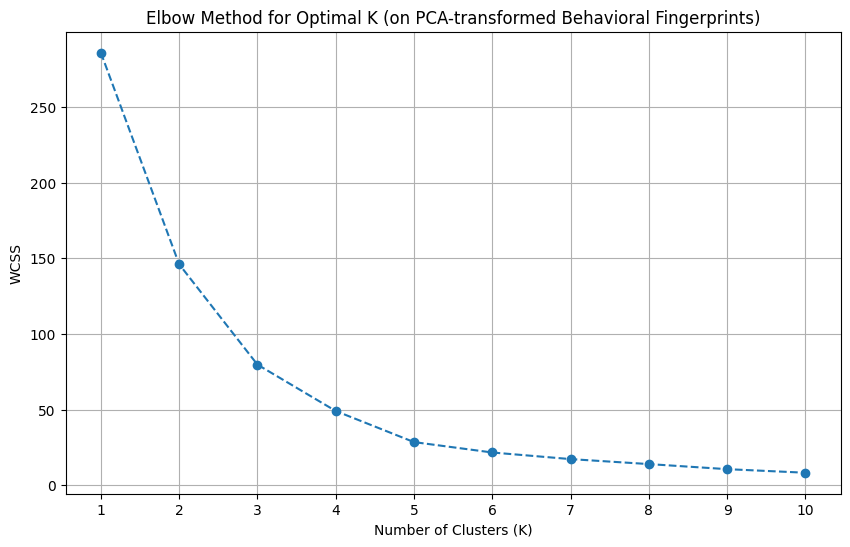

Elbow method plot generated to determine optimal number of clusters for K-means.


In [70]:
wcss = []
max_clusters = min(len(behavioral_fingerprints_pca), 10) # Max 10 clusters or number of samples if less

for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(behavioral_fingerprints_pca)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K (on PCA-transformed Behavioral Fingerprints)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.xticks(range(1, max_clusters + 1))
plt.grid(True)
plt.show()

print("Elbow method plot generated to determine optimal number of clusters for K-means.")

**Reasoning**:
Based on the elbow plot generated previously, I will choose an optimal number of clusters (e.g., 3 or 4, visually inspecting the plot for the 'elbow' point) and apply K-means clustering to the PCA-transformed behavioral fingerprints. This will assign each model to a cluster, grouping models with similar behavioral characteristics.



In [71]:
n_clusters = 4 # Visually chosen from the elbow plot, adjust if needed
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42, n_init=10)
clusters = kmeans.fit_predict(behavioral_fingerprints_pca)

# Add cluster labels to the behavioral_fingerprints_full_data DataFrame
behavioral_fingerprints_full_data['cluster'] = clusters

print(f"K-means clustering applied with {n_clusters} clusters.")
print("First 5 rows of Behavioral Fingerprints with cluster assignments:")
print(behavioral_fingerprints_full_data.head())

K-means clustering applied with 4 clusters.
First 5 rows of Behavioral Fingerprints with cluster assignments:
                  accuracy  f1_score  precision    recall  cm_true_0_pred_0  \
qwen_0.5b        -1.036334 -0.704560  -1.100125 -1.022472         -0.306899   
qwen_1.5b        -0.998365 -0.865233   0.340032 -1.017941         -1.541330   
qwen_7b           2.805891  2.533455   1.665505  2.833482          1.368683   
stable_zephyr_3b  0.199478  0.333338   1.257269  0.209556         -1.278222   
stable2_1.6b     -1.286186 -1.873371  -2.561714 -1.246825          0.470555   

                  cm_true_0_pred_1  cm_true_0_pred_2  cm_true_0_pred_3  \
qwen_0.5b                -0.948581          0.166584          1.753677   
qwen_1.5b                 1.365461          1.123822          0.263415   
qwen_7b                   0.032170         -1.091500         -0.946292   
stable_zephyr_3b          2.081144         -0.134262          0.019060   
stable2_1.6b             -1.611251         -1

**Reasoning**:
After applying K-means clustering and assigning clusters to each model, the next step is to visualize these clusters in the PCA-reduced space. This will help us understand the groupings of models with similar behavioral fingerprints.



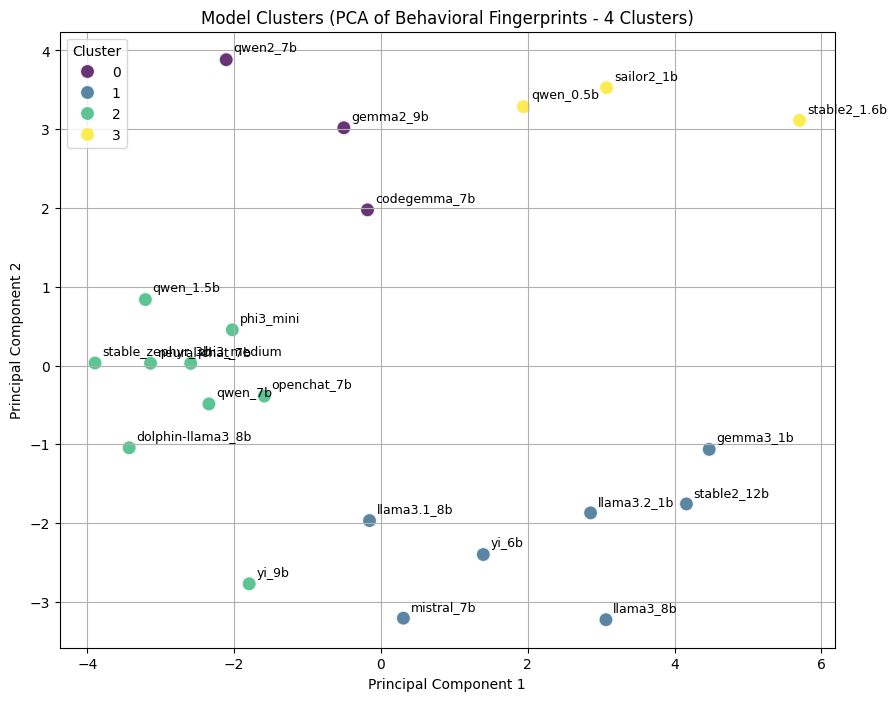

Visualization of model clusters based on 4 clusters generated.


In [72]:
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=behavioral_fingerprints_pca[:, 0],
    y=behavioral_fingerprints_pca[:, 1],
    hue=clusters,
    palette='viridis',
    s=100, # size of points
    alpha=0.8
)

# Annotate each point with the model name
for i, model_name in enumerate(behavioral_fingerprints_full_data.index):
    plt.annotate(
        model_name,
        (behavioral_fingerprints_pca[i, 0] + 0.1, behavioral_fingerprints_pca[i, 1] + 0.1),
        fontsize=9
    )

plt.title(f'Model Clusters (PCA of Behavioral Fingerprints - {n_clusters} Clusters)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

print(f"Visualization of model clusters based on {n_clusters} clusters generated.")

**Reasoning**:
The subtask requires exporting the full disagreement scores, the top-N high-disagreement samples, and the model-level results (including clustering information) to CSV files. I will save the `disagreement_scores`, `df_high_disagreement`, and `behavioral_fingerprints_full_data` DataFrames to separate CSV files.



In [77]:
disagreement_scores.to_csv('full_disagreement_scores.csv', index=True)
df_high_disagreement.to_csv(f'top_{N}_high_disagreement_samples.csv', index=False)
behavioral_fingerprints_full_data.to_csv('model_behavioral_fingerprints_with_clusters.csv', index=True)

print("Exported 'full_disagreement_scores.csv'")
print(f"Exported 'top_{N}_high_disagreement_samples.csv'")
print("Exported 'model_behavioral_fingerprints_with_clusters.csv'")

Exported 'full_disagreement_scores.csv'
Exported 'top_1000_high_disagreement_samples.csv'
Exported 'model_behavioral_fingerprints_with_clusters.csv'


In [79]:
df2 = pd.read_csv(f'top_{N}_high_disagreement_samples.csv', index_col=0)
df2

,label,ending0,ending1,ending2,ending3,qwen_0.5b_pred,qwen_0.5b_correct,qwen_1.5b_pred,qwen_1.5b_correct,qwen_7b_pred,...,phi3_mini_pred,phi3_mini_correct,sailor2_1b_pred,sailor2_1b_correct,llama3.2_1b_pred,llama3.2_1b_correct,llama3_8b_pred,llama3_8b_correct,gemma2_9b_pred,gemma2_9b_correct
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
8449,2,Reshape your hands after 10 and 20 drops of du...,Place the fingers of your two hands on the sid...,Do this to avoid painful application of the du...,Remove it from the lamp until you feel relief ...,3,False,1,False,2,...,2,True,3,False,-2,False,-2,False,0,False
8055,1,This oval should form a circle in the bottom e...,Click and hold the circle and tap on create oval,While still selected click on the orange color,This is the body of the ladybug,1,True,3,False,3,...,2,False,0,False,2,False,1,True,0,False
5636,3,Speak in a firm voice that focuses the convers...,This is a good way to keep distance between yo...,For example i am a fragile person,this statement will help take the focus off of...,1,False,2,False,1,...,3,True,-2,False,3,True,2,False,3,True
5037,1,Because the plaintiff waited for permission to...,Because you used obscene or hazardous material...,note that this intrusion does not need to be p...,the invasion would be offensive to a reasonabl...,0,False,2,False,3,...,-2,False,2,False,0,False,0,False,3,False
5103,3,Think about defining the two dividencies and s...,Doing this may help you organize the problem s...,Do the same with all the dividend bars includi...,Make a formula to solve the problem,0,False,2,False,1,...,1,False,0,False,0,False,0,False,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1521,1,is shown while he is standing on a ladder trim...,talks about the experience,follows suit to cut the wooden pieces and then...,is shown doing the same thing and the first ma...,1,True,2,False,3,...,3,False,0,False,1,True,2,False,3,False
318,1,appears on screen and all the cheerleaders beg...,remains on the bottom right area of the screen...,appears on screen with pictures of the horses ...,appears and the couple horses are shown indivi...,0,False,3,False,2,...,3,False,3,False,0,False,0,False,0,False
9217,2,Its best to substitute two minced cloves for t...,Substitute a pinch of cumin for extra flavor i...,The cayenne pepper adds a metallic flavor to t...,Wait for the glaze to soften,2,True,3,False,1,...,1,False,3,False,0,False,0,False,2,True
